In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle("Data/df_with_history_>10_orders.pkl")

In [3]:
# Get the mean of all differences and use it as the prediction for all orders
mean = np.mean(df["difference"])
df["all_prediction"] = mean

In [4]:
# Calculate RMSE for the mean guess prediction
y_test = df["difference"]
y_pred = df["all_prediction"]

mse_test = mean_squared_error(y_test, y_pred)
print(f"Mean RMSE for all customers: {np.round(np.sqrt(mse_test),2)}.")

Mean RMSE for all customers: 18.71.


In [5]:
y_test.reset_index(drop=True, inplace=True)
y_pred.reset_index(drop=True, inplace=True)

In [6]:
# Get a list of all percent errors
percentages = []

for idx, val in enumerate(y_pred):
    perc = np.abs(val-y_test[idx])/y_test[idx]
    percentages.append(perc)

In [7]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.02
Maximum percent error: 16.63
Mean percent error: 1.17


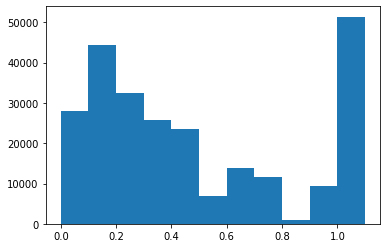

In [8]:
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [9]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 154266
Percentage of orders with a percent error lower than 0.5: 0.62


In [10]:
# Get the differences between predicted and true values
differences = []

for idx, val in enumerate(y_test):
    differences.append(np.abs(val-y_pred[idx]))

In [11]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in differences]

In [12]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.11
Percentage of orders predicted correctly within 3 days: 0.27
Percentage of orders predicted correctly within 5 days: 0.42
Percentage of orders predicted correctly within 7 days: 0.55


In [13]:
recipients = []

for i in df["recipient"]:
    if i not in recipients:
        recipients.append(i)
        
print(len(recipients))

3600


In [14]:
# For each customer, get the mean and use it as a prediction for all orders by the customer
df_new = pd.DataFrame(columns = df.columns)

for i in recipients:
    test = df[df.recipient == i]
    mean = np.mean(test["difference"])
    
    test["prediction"] = mean
            
    df_new = pd.concat([df_new, test])

In [15]:
# Calculate the RMSE for each customer, and get the percent errors and differences for predicted and true values
rmse_values = []
final_differences = []
final_percentages = []

for i in recipients:
    test = df_new[df_new.recipient == i]
    differences = []
    percentages = []
    
    y_test = test["difference"]
    y_pred = test["prediction"]
    
    mse_test = mean_squared_error(y_test, y_pred)
    
    rmse_values.append(np.sqrt(mse_test))
    
    y_test.reset_index(drop=True, inplace=True)
    y_pred.reset_index(drop=True, inplace=True)
    
    for idx, val in enumerate(y_pred):
        perc = np.abs(val-y_test[idx])/y_test[idx]
        percentages.append(perc)
        
    final_percentages.append(np.mean(percentages))

    for idx, val in enumerate(y_test):
        differences.append(np.abs(val-y_pred[idx]))
        
    final_differences.append(differences)

In [16]:
print(f"Mean of the mean RMSE per customer: {np.round(np.mean(rmse_values),2)}.")
print(f"Smallest mean RMSE: {np.round(np.min(rmse_values),2)}.")
print(f"Largest mean RMSE: {np.round(np.max(rmse_values),2)}.")

Mean of the mean RMSE per customer: 11.68.
Smallest mean RMSE: 0.82.
Largest mean RMSE: 218.37.


In [17]:
print(f"Mean of the mean RMSE per customer, without the 150 largest values: {np.round(np.average(sorted(rmse_values)[0:-150]),2)}.")

Mean of the mean RMSE per customer, without the 150 largest values: 8.95.


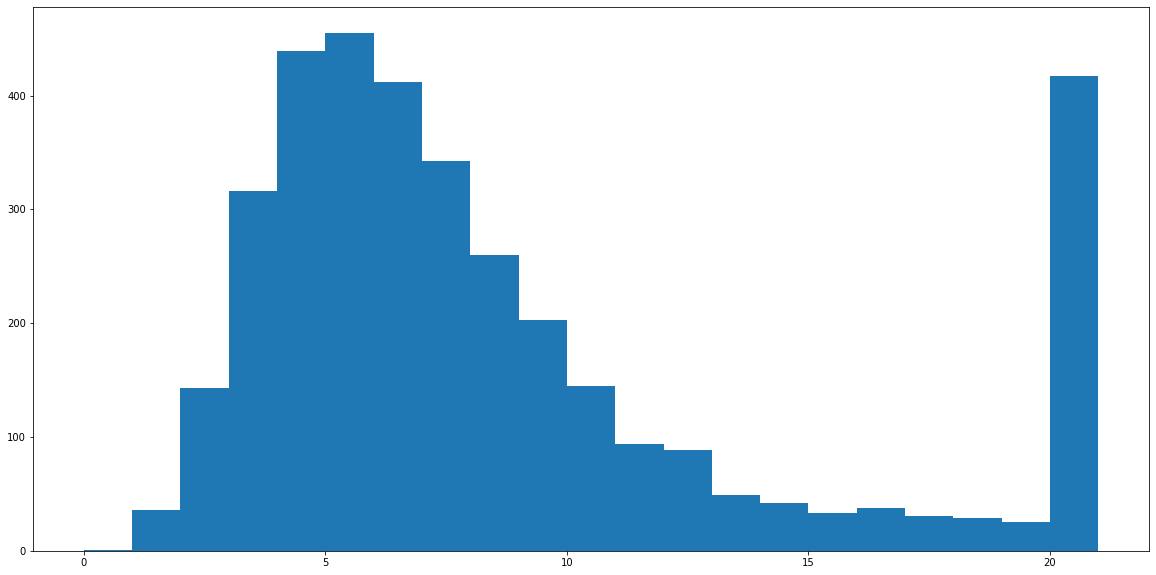

In [18]:
rmse_values_array = np.asarray(rmse_values)

plt.figure(figsize=(20,10))

plt.hist(rmse_values_array.clip(min=0, max=21), range=[0,21], bins=21)
plt.show()

In [19]:
lower = []

for i in rmse_values:
    if i <= 5:
        lower.append(i)

print(f"Number of customers with an RMSE lower than 5: {len(lower)}")
print(f"Percentage of customer with an RMSE lower than 5: {np.round(len(lower)/len(rmse_values),2)}")

Number of customers with an RMSE lower than 5: 935
Percentage of customer with an RMSE lower than 5: 0.26


In [20]:
print(f"Minimum percent error: {np.round(np.min(final_percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(final_percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(final_percentages),2)}")

Minimum percent error: 0.05
Maximum percent error: 11.57
Mean percent error: 0.81


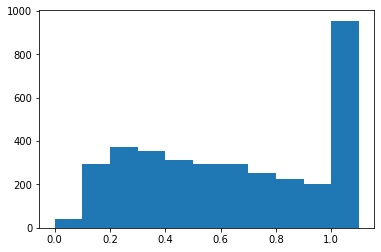

In [21]:
final_percentages = np.asarray(final_percentages)

plt.hist(final_percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [22]:
lower = []

for i in final_percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(final_percentages),2)}")

Number of orders with a percent error lower than 0.5: 1374
Percentage of orders with a percent error lower than 0.5: 0.38


In [23]:
final_diffs = [np.mean(lst) for lst in final_differences]

In [24]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in final_diffs]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in final_diffs]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in final_diffs]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in final_diffs]

In [25]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(final_diffs),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(final_diffs),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(final_diffs),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(final_diffs),2)}")

Percentage of orders predicted correctly within 1 day: 0.01
Percentage of orders predicted correctly within 3 days: 0.21
Percentage of orders predicted correctly within 5 days: 0.52
Percentage of orders predicted correctly within 7 days: 0.72
